# Plot Marginsplot from exported STATA results

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns

# svg font settings
import matplotlib
matplotlib.rcParams['svg.fonttype'] = 'none'

In [3]:
path = "/zfs/projects/faculty/amirgo-management/code_review_data/agent/"

In [3]:
explicit_df = pd.read_csv(path + "explicit_agent.csv")
implicit_df = pd.read_csv(path + "implicit_agent.csv")

In [4]:
label_dict = {
    "Gender": "Gender",
    "Age": "Age",
    "IfCollege": "Education",
    "IfBusEd": "Business Education",
    "IfBusJob": "Occupation"}

age_dict = {
    "30s or younger": "≤30s",
    "40s-60s": "40s-60s",
    "70s or older": "≥70s"}

In [15]:
def plot_trend_with_ci(df, if_implicit=False):
    variables = df['VariableName'].unique()
    subplot_size = 4
    fig, ax = plt.subplots(nrows=1, ncols=len(variables), figsize=(subplot_size * len(variables), subplot_size))
    plt.subplots_adjust(wspace=0.3)

    if len(variables) == 1:
        ax = [ax]

    for i, var in enumerate(variables):
        df_var = df[df['VariableName'] == var]
        levels = df_var['Variable'].unique()
        colors = sns.color_palette("colorblind", len(levels))

        for j, level in enumerate(levels):
            df_level = df_var[df_var['Variable'] == level]
            if var == 'Age':
                level = age_dict.get(level, level)
            ax[i].plot(df_level['Decade'], df_level['Coefficient'], color=colors[j], alpha=0.7, label=level)
            ax[i].fill_between(df_level['Decade'], df_level['95% lower bound'], df_level['95% upper bound'],
                               color=colors[j], alpha=0.3)

        # add vertical lines for 1980s
        ax[i].axvline(x=1980, color='gray', linestyle='dashed', linewidth=1, alpha=0.5)

        # labels
        ax[i].set_xlabel('Decade', fontsize=16)
        if i == 0:
            ylabel = 'Implicit Metaphor Score (Exp.)' if if_implicit else 'Explicit Metaphor Probability'
            ax[i].set_ylabel(ylabel, fontsize=16)

        # ticks
        # xticks change font size
        ax[i].tick_params(axis='x', labelsize=14)
        # y-axis ticks change to log scale if implicit
        ymin, ymax = ax[i].get_ylim()
        log_ticks = np.linspace(ymin, ymax, 4)  # 4 sparse ticks
        ax[i].set_yticks(log_ticks)
        if if_implicit:
            ax[i].set_yticklabels([f"{np.exp(t):.3f}" for t in log_ticks], fontsize=14)
        else:
            ax[i].set_yticklabels([f"{t:.3f}" for t in log_ticks], fontsize=14)

        ax[i].spines['top'].set_visible(False)
        ax[i].spines['right'].set_visible(False)
        ax[i].legend(title=label_dict.get(var, var), frameon=False, fontsize=14).get_title().set_fontsize(14)


    return fig


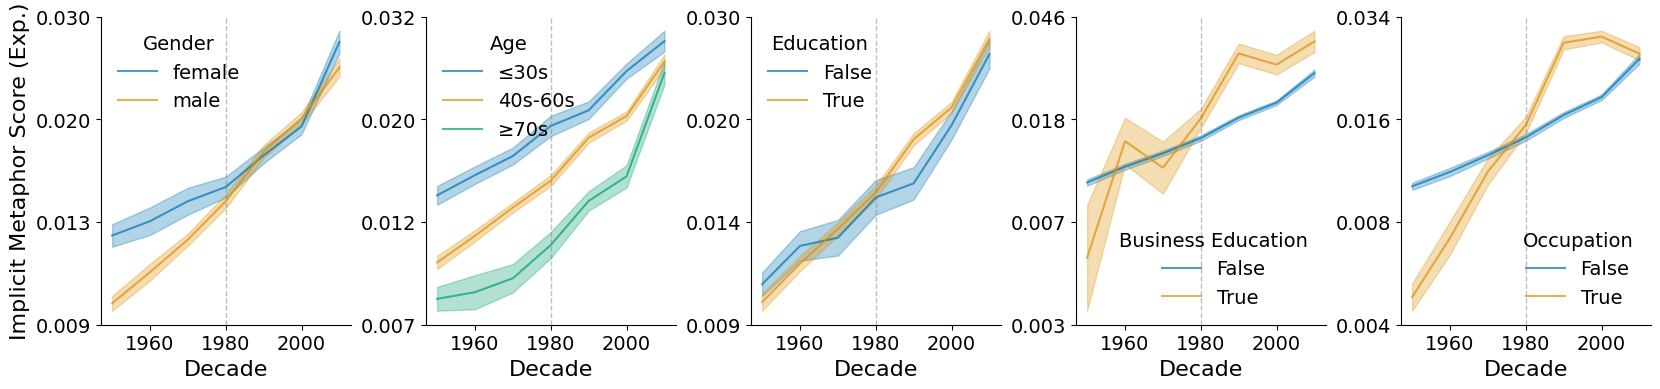

In [16]:
implicit_fig = plot_trend_with_ci(implicit_df, if_implicit=True)

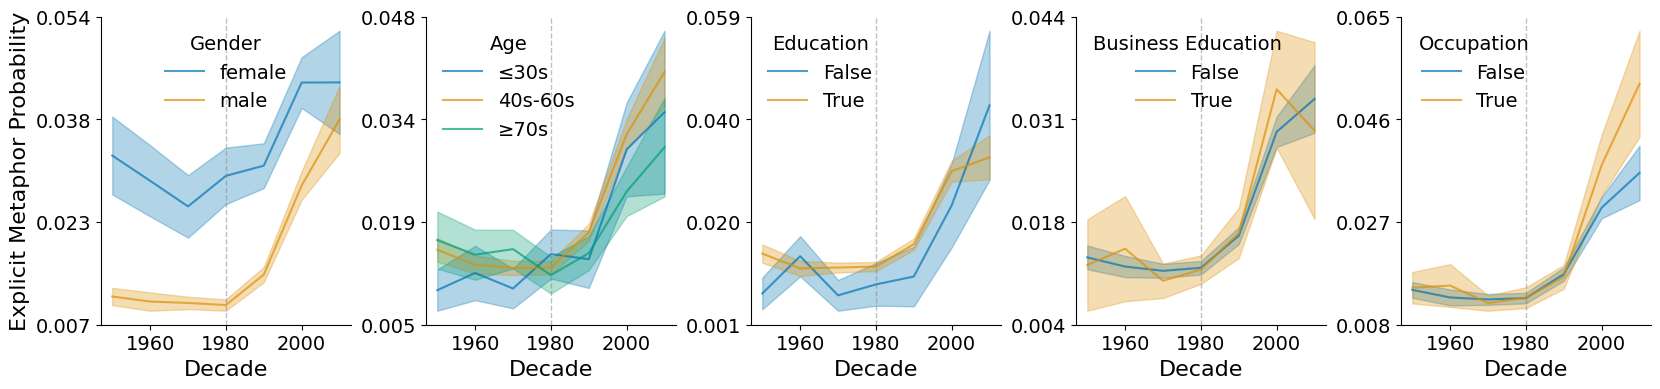

In [17]:
explicit_fig = plot_trend_with_ci(explicit_df)

In [18]:
# save
figure_path = "/zfs/projects/faculty/amirgo-management/code_review_data/figure/"
implicit_fig.savefig(figure_path+'imlicit_agent.svg', format='svg', bbox_inches='tight', dpi=300, transparent=True)
explicit_fig.savefig(figure_path+'explicit_agent.svg', format='svg', bbox_inches='tight', dpi=300, transparent=True)

# AVP

In [4]:
df = pd.read_csv(path + "avp_agent.csv")

In [20]:
level_dict = {
    "<=$12,000": "≤$12k",
    "$12,001-$36,000": "$12-36k",
    "$36,001-$72,000": "$36-72k",
    ">$72,000": ">$72k",
    "less than high school": "Less Than\nHS",
    "high school": "HS",
    "some college": "Some\nCollege",
    "bachelor's degree or higher": "Bachelor\nOr Higher",
    "Democrat": "D",
    "Republican": "R",
    "Female": "F",
    "Male": "M"}


In [21]:
df = df[~(df['level']=='Other')].copy()
# change the name AHI to annual household income
df['variable'] = df['variable'].replace({
    "AHI": "Annual Household Income"})
df['level'] = df['level'].replace(level_dict)
df['err'] = (df['conf.high'] - df['conf.low'])/ 2

In [22]:
def plot_avp(df):
    variables = ['Annual Household Income', 'Education','Age', 'Race', 'Gender', 'Party',]

    # Compute width ratios dynamically based on number of levels
    width_ratios = [df[df['variable'] == var]['level'].nunique() for var in variables]
    
    # Set up figure and GridSpec with custom widths
    fig = plt.figure(figsize=(sum(width_ratios)*1.1, 4))
    gs = gridspec.GridSpec(1, len(variables), width_ratios=width_ratios, wspace=0.4, height_ratios=[1])

    # For each variable, plot the estimate with confidence intervals
    for i, var in enumerate(variables):
        df_var = df[df['variable'] == var]
        levels = df_var['level'].unique()

        x_pos = np.arange(len(levels))
        estimates = df_var['estimate'].values
        errors = df_var['err'].values

        ax = fig.add_subplot(gs[0, i])
        ax.errorbar(x_pos, estimates, yerr=errors, fmt='o', color="#0173b2", capsize=5)
        ax.set_xticks(x_pos)
        ax.set_xticklabels(levels, fontsize=12)

        # x lim
        if len(levels) ==2:
            margin = 0.3
            ax.set_xlim(x_pos[0] - margin, x_pos[-1] + margin)

        # # y-axis ticks change to log scale if implicit
        ymin, ymax = ax.get_ylim()
        log_ticks = np.linspace(ymin, ymax, 4)  # 4 sparse ticks
        ax.set_yticks(log_ticks)
        ax.set_yticklabels([f"{np.exp(t):.3f}" for t in log_ticks], fontsize=14)

        if i == 0:
            ax.set_ylabel('Implicit Metaphor Score (Exp.)', fontsize=16)

        ax.set_title(var, fontsize=16)
    return fig

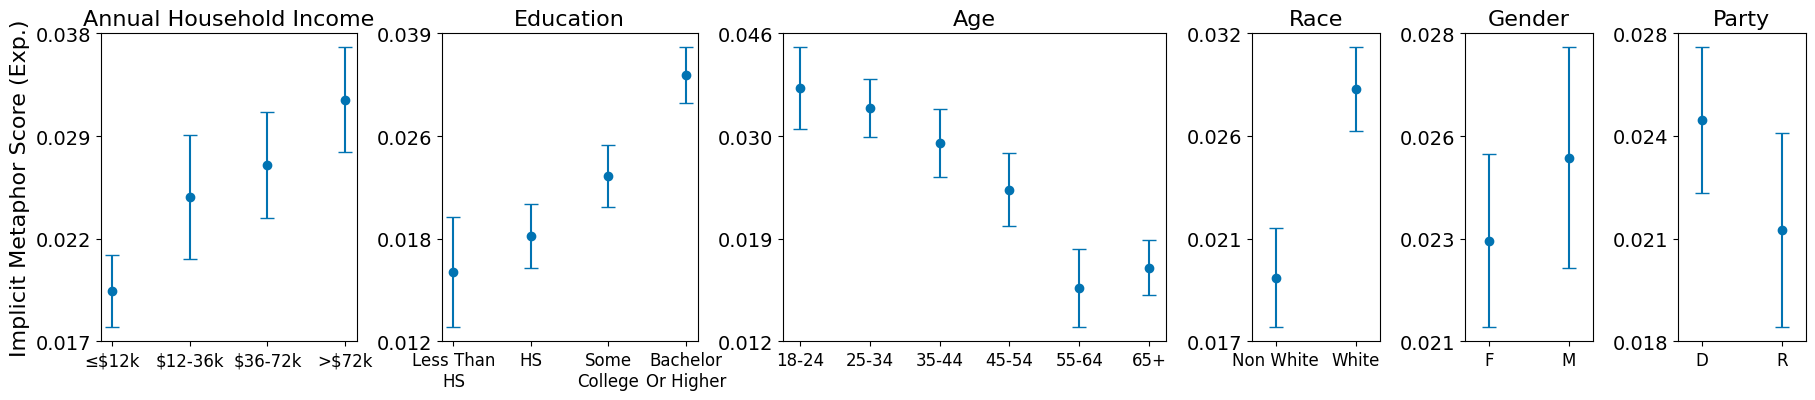

In [23]:
avp_fig = plot_avp(df)

In [24]:
avp_fig.savefig(figure_path+'avp_agent.svg', format='svg', bbox_inches='tight', dpi=300, transparent=True)

In [8]:
# export df to latex table
df_to_print = df[['variable', 'level', 'estimate', 'std.error', 'statistic', 'p.value', 'conf.low', 'conf.high']].copy()
df_to_print['estimate'] = df_to_print['estimate'].apply(lambda x: f"{x:.3f}")
df_to_print['std.error'] = df_to_print['std.error'].apply(lambda x: f"{x:.3f}")
df_to_print['statistic'] = df_to_print['statistic'].apply(lambda x: f"{x:.3f}")
df_to_print['p.value'] = df_to_print['p.value'].apply(lambda x: f"{x:.3f}")
df_to_print['conf.low'] = df_to_print['conf.low'].apply(lambda x: f"{x:.3f}")
df_to_print['conf.high'] = df_to_print['conf.high'].apply(lambda x: f"{x:.3f}") 

# save to latex
df_to_print.to_latex(path + "avp_agent.tex", index=False, float_format="%.3f",
                     column_format='lccccccc',
                     header=['Variable', 'Level', 'Estimate', 'Std. Error', 'Statistic', 'p-value', 'Conf. Low', 'Conf. High'],
                     escape=False, caption='Agent Analysis: AVP Results',
                     label='tab:avp_agent')